#💊 Breaking Bad Analysis — Joldea & Lazarov

###**Idea**

Explore Breaking Bad

###**Topics applied**

1.   Data Cleaning & Preprocessing
2.   Web Scraping
3.   TF-IDF
4.   N-Grams
5.   NER
6.   Sentiment analysis


###**Links**

*   [Presentation](https://docs.google.com/presentation/d/16-MejheMIMEwRZegN9t8yvAJ3qfnrGJa0WbxO_8Az2o/edit?usp=sharing)

*   [Requirements](https://docs.google.com/document/d/1z6e_-aCAP7-SPu7sFJirR--yK4ZnZS0KJChC48TXMBU/edit?usp=sharing)

*   [Breaking Bad dataset](https://www.kaggle.com/datasets/varpit94/breaking-bad-tv-show-all-seasons-episodes-data)

*   [Breaking Bad script](https://subslikescript.com/series/Breaking_Bad-903747)

# Installs

In [ ]:
!pip install nltk
!pip install requests
!pip install beautifulsoup4
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Imports & Downloads

In [ ]:
import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt
import seaborn as sns

import time
import requests
from bs4 import BeautifulSoup
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
import spacy
from collections import Counter
from PIL import Image
import urllib.request

import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.metrics import TrigramAssocMeasures
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#Technical Topics

##Data Cleaning & Preprocessing

###Load the dataset into a DataFrame

In [ ]:
# We previously uploaded the dataset on pastebin for easier access.
df = pd.read_csv('https://pastebin.com/raw/dGUwSj1u')
df.head(5)

,Date,Season,Episode,Title,Directed by,Written by,Duration_mins,Summary,Rating_IMDB,U.S. viewers_million
0,20-Jan-08,1,1,Pilot,Vince Gilligan,Vince Gilligan,58,"Diagnosed with terminal lung cancer, chemistry...",9.1,1.41
1,27-Jan-08,1,2,Cat's in the Bag...,Adam Bernstein,Vince Gilligan,48,After their first drug deal goes terribly wron...,8.7,1.49
2,10-Feb-08,1,3,...And the Bag's in the River,Adam Bernstein,Vince Gilligan,48,Walt and Jesse clean up after the bathtub inci...,8.8,1.08
3,17-Feb-08,1,4,Cancer Man,Jim McKay,Vince Gilligan,48,Walt tells the rest of his family about his ca...,8.3,1.09
4,24-Feb-08,1,5,Gray Matter,Tricia Brock,"Vince Gilligan, Patty Lin",48,Walt rejects everyone who tries to help him wi...,8.4,0.97


###Look for NaN values

In [ ]:
df.isna().sum()

Date                    0
Season                  0
Episode                 0
Title                   0
Directed by             0
Written by              0
Duration_mins           0
Summary                 0
Rating_IMDB             0
U.S. viewers_million    5
dtype: int64

In [ ]:
df[df.isna().any(axis=1)]

,Date,Season,Episode,Title,Directed by,Written by,Duration_mins,Summary,Rating_IMDB,U.S. viewers_million
13,19-Apr-09,2,7,Negro y Azul,Félix Enríquez Alcalá,"Vince Gilligan, John Shiban",47,Rumor is spreading that Jesse killed the man t...,8.7,NaN
15,03-May-09,2,9,4 Days Out,Michelle MacLaren,"Vince Gilligan, Sam Catlin",47,Walt and Jesse become stranded out in the midd...,9.2,NaN
16,10-May-09,2,10,Over,Phil Abraham,"Vince Gilligan, Moira Walley-Beckett, J. Roberts",47,Walt's cancer has greatly improved. Time to ce...,8.6,NaN
17,17-May-09,2,11,Mandala,Adam Bernstein,"Vince Gilligan, George Mastras",47,Walt and Jesse's little empire begins to crumb...,8.9,NaN
18,24-May-09,2,12,Phoenix,Colin Bucksey,"Vince Gilligan, John Shiban",47,Walt and Skyler have a baby girl. Now that Jes...,9.3,NaN


###Fill NaN values

In [ ]:
# Fill NaN values with median values by grouping by 'Season' column
df['U.S. viewers_million'] = df.groupby('Season')['U.S. viewers_million'].transform(lambda x: x.fillna(x.median()))

##Web Scraping

###Get the script for each episode (≤ 1 min)

In [ ]:
class Episode:
  def __init__(self, title, season, number):
      self.title  = title
      self.season = season
      self.number = number
      self.script = ""

episodes = [Episode(title  = row['Title'  ].replace(" ", "_"),
                    season = row['Season' ],
                    number = row['Episode']) for index, row in df.iterrows()]

def get_script(episode, slow = False):
  url = f'https://subslikescript.com/series/Breaking_Bad-903747/season-{episode.season}/episode-{episode.number}-{episode.title}'
  response = requests.get(url, allow_redirects=True)
  if slow:  # Website can block access when requesting too much
    time.sleep(0.25)

  script_div = BeautifulSoup(response.text, 'html.parser').find('div', class_='full-script')
  if script_div:
    episode.script = script_div.get_text('\n')
  else:
    print("Error getting webpage. Retrying...")
    time.sleep(5)
    get_script(episode, True)

# Extract the scripts
for episode in episodes:
  get_script(episode)

# Add the scripts as a new column to the dataframe
df['Script'] = [episode.script for episode in episodes]
df

,Date,Season,Episode,Title,Directed by,Written by,Duration_mins,Summary,Rating_IMDB,U.S. viewers_million,Script
0,20-Jan-08,1,1,Pilot,Vince Gilligan,Vince Gilligan,58,"Diagnosed with terminal lung cancer, chemistry...",9.1,1.41,My name is\nWalter Hartwell White.\nI live at\...
1,27-Jan-08,1,2,Cat's in the Bag...,Adam Bernstein,Vince Gilligan,48,After their first drug deal goes terribly wron...,8.7,1.49,"Subs collected, corrected and if necessary ada..."
2,10-Feb-08,1,3,...And the Bag's in the River,Adam Bernstein,Vince Gilligan,48,Walt and Jesse clean up after the bathtub inci...,8.8,1.08,[♪♪♪]\n[GRUNTS]\n[COUGHS]\nWALT:\nLet's break ...
3,17-Feb-08,1,4,Cancer Man,Jim McKay,Vince Gilligan,48,Walt tells the rest of his family about his ca...,8.3,1.09,HANK:\nOperation Icebreaker.\nHow we liking th...
4,24-Feb-08,1,5,Gray Matter,Tricia Brock,"Vince Gilligan, Patty Lin",48,Walt rejects everyone who tries to help him wi...,8.4,0.97,"Here's my r?sum?.\nI mean, technically\nit say..."
...,...,...,...,...,...,...,...,...,...,...,...
57,01-Sep-13,5,12,Rabid Dog,Sam Catlin,"Vince Gilligan, Sam Catlin",48,Walt discovers Jesse broke into his house and ...,9.2,4.41,Jesse!?\nJesse!\nYou show yourself right now!\...
58,08-Sep-13,5,13,To'hajiilee,Michelle MacLaren,"Vince Gilligan, George Mastras",47,Jesse and Hank come up with an idea to take Wa...,9.8,5.11,"So, how big's the batch?\nShould be about 50 p..."
59,15-Sep-13,5,14,Ozymandias,Rian Johnson,"Vince Gilligan, Moira Walley-Beckett",48,Walt goes on the run. Jesse is taken hostage. ...,10.0,6.37,"Mm-hmm.\nYo, so what's next?\nWe wait.\nYou do..."
60,22-Sep-13,5,15,Granite State,Peter Gould,"Vince Gilligan, Peter Gould",55,Walt struggles as he adapts to aspects of his ...,9.7,6.58,You can come on out.\nIt's an actual store.\nM...


##TF-IDF

###Get the whole script

In [ ]:
allowed_chars = string.ascii_letters + string.digits + string.whitespace
concatenated_script = df['Script'].str.cat()
concatenated_script = ''.join(c for c in concatenated_script if c in allowed_chars)
concatenated_script

'My name is\nWalter Hartwell White\nI live at\n308 Negra Arroyo Lane\nAlbuquerque New Mexico\n87104\nTo all law enforcement entitles\nthis is not an admission of guilt\nI am speaking\nto my family now\nSkyler\nyou are the love\nof my life\nI hope you know that\nWalter Junior\nyoure my big man\nThere are\n\n\n\n\n\n\nThere are going\nto be some\nthings things\nthat youll come to learn\nabout me in the next few days\nI just want you to know\nthat no no matter\nhow it may look\nI only had you in my heart\nGoodbye\nTranscript  SwSub\nSync  niklas\nHappy Birthday\nLook at that\nThat is veggie bacon\nBelieve it or not\nZero cholesterol\nYou wont even taste\nthe difference\nWhat time do you think\nyoull be home\n\n\n\n\n\n\nSame time\nI dont want him dicking\nyou around tonight\nYou get paid till 5\nyou work till 5 no later\nHey\n Happy Birthday\n Well thank you\nYoure late again\nThere was no\nhot water again\nI have an easy fix\nfor that\nYou wake up early\nand then you get to be\nthe first

### Make a dataframe

In [ ]:
concatenated_script_lines = concatenated_script.splitlines()

concatenated_script_df = pd.DataFrame({
    "line": concatenated_script_lines,
    "line_number": list(range(len(concatenated_script_lines)))
})

concatenated_script_df['word'] = concatenated_script_df['line'].str.split()

concatenated_script_df = concatenated_script_df.explode('word')

concatenated_script_df = concatenated_script_df.reset_index(drop=True)
concatenated_script_df.head(100)


,line,line_number,word
0,My name is,0,My
1,My name is,0,name
2,My name is,0,is
3,Walter Hartwell White,1,Walter
4,Walter Hartwell White,1,Hartwell
...,...,...,...
95,how it may look,30,may
96,how it may look,30,look
97,I only had you in my heart,31,I
98,I only had you in my heart,31,only


### Word count

In [ ]:
count_df = concatenated_script_df.groupby('word')['word'].count()

count_df_sorted = count_df.sort_values(ascending=False)

pd.set_option('display.max_rows', 10)
count_df_sorted.head(10)

word
you     6287
I       6194
the     4711
to      4407
a       3808
it      2813
that    2417
and     2299
of      2252
me      2010
Name: word, dtype: int64

### Remove stopwords

In [ ]:
stop_words = set(stopwords.words('english'))
concatenated_script_df['word_lower'] = concatenated_script_df['word'].str.lower()
count_df_filtered = concatenated_script_df[~concatenated_script_df['word_lower'].isin(stop_words)].groupby('word')['word'].count().sort_values(ascending=False)
count_df_filtered.head(10)

word
know     1696
Im       1442
right    1261
Yeah     1221
dont     1080
like      946
got       827
get       797
Oh        741
Hey       721
Name: word, dtype: int64

##N-Grams

###Bigrams

In [ ]:
tokens = word_tokenize(concatenated_script)
bigrams_list = list(nltk.bigrams(tokens))
bigrams_df = pd.DataFrame(bigrams_list, columns=['Word 1', 'Word 2'])
bigrams_df['Bigram'] = bigrams_df['Word 1'] + ' ' + bigrams_df['Word 2']
bigrams_df

,Word 1,Word 2,Bigram
0,My,name,My name
1,name,is,name is
2,is,Walter,is Walter
3,Walter,Hartwell,Walter Hartwell
4,Hartwell,White,Hartwell White
...,...,...,...
210140,have,for,have for
210141,for,you,for you
210142,you,my,you my
210143,my,baby,my baby


In [ ]:
def is_stopword(word):
    return word.lower() in stopwords or word.lower() in ['dont', 'gon', 'na', 'wan', 'got', 'ta', 'yeah', 'right']

bigrams_df_filtered = bigrams_df[~(bigrams_df['Word 1'].apply(is_stopword) | bigrams_df['Word 2'].apply(is_stopword))]
top_bigrams = bigrams_df_filtered['Bigram'].value_counts().head(20)
print(top_bigrams)

Im sorry         124
Mr White         102
Hey Hey           57
car wash          54
Oh God            52
Im going          42
Jesse Jesse       39
Jesse Pinkman     37
Okay Okay         35
Uncle Hank        35
look like         34
Walter White      34
Lets go           33
Ill tell          30
Oh hey            29
Im sure           28
last night        28
make sure         27
even know         25
Im thinking       25
Name: Bigram, dtype: int64


###Trigrams

In [ ]:
trigrams_list = list(nltk.trigrams(tokens))
trigrams_df = pd.DataFrame(trigrams_list, columns=['Word 1', 'Word 2', 'Word 3'])
trigrams_df['Trigram'] = trigrams_df['Word 1'] + ' ' + trigrams_df['Word 2'] + ' ' + trigrams_df['Word 3']
trigrams_df

,Word 1,Word 2,Word 3,Trigram
0,My,name,is,My name is
1,name,is,Walter,name is Walter
2,is,Walter,Hartwell,is Walter Hartwell
3,Walter,Hartwell,White,Walter Hartwell White
4,Hartwell,White,I,Hartwell White I
...,...,...,...,...
210139,I,have,for,I have for
210140,have,for,you,have for you
210141,for,you,my,for you my
210142,you,my,baby,you my baby


In [ ]:
trigrams_df_filtered = trigrams_df[~(trigrams_df['Word 1'].apply(is_stopword) | trigrams_df['Word 2'].apply(is_stopword) | trigrams_df['Word 3'].apply(is_stopword))]
top_trigrams = trigrams_df_filtered['Trigram'].value_counts().head(20)
print(top_trigrams)

Im sorry Im              14
Hey hey hey              13
Jesse Jesse Jesse        12
second cell phone        10
Hey Hey Hey               9
sorry Im sorry            8
Whoa whoa whoa            8
Wait wait wait            7
Hey Mr White              7
Oh God Oh                 7
car wash professional     7
Negra Arroyo Lane         7
Hey Dad Hey               6
308 Negra Arroyo          6
tudo que sei              6
four little words         6
ela tudo que              6
blah blah blah            6
Encontrei ela tudo        6
34 59 20                  6
Name: Trigram, dtype: int64


##NER

### Find the most common names

In [ ]:
nlp = spacy.load('en_core_web_sm')

chunk_size = 100000  # Define the size of each chunk
chunks = [concatenated_script[i:i+chunk_size] for i in range(0, len(concatenated_script), chunk_size)]

person_names = []
for chunk in chunks:
    doc = nlp(chunk)
    person_names.extend([entity.text for entity in doc.ents if entity.label_ == 'PERSON'])

most_common_persons = Counter(person_names).most_common(20)

for name, count in most_common_persons:
    print(name, count)

Walt 323
Skyler 202
Hank 185
Jesse 182
Marie 120
Mike 85
Gus 72
Jesus 65
Walter 41
Tuco 36
Flynn 32
Shut 31
Jesse Pinkman 30
Walter White 29
Gale 28
Ted 25
Son 22
Saul 21
Jack 20
Elliott 18


###Improve results (≤ 2 min)

Since we're interested in the most relevant characters in the series, we should group names referring to the same character together (e.g.: Walt, Walter, Walter White or Jesse, Jesse Pinkman).

In [ ]:
nlp = spacy.load('en_core_web_sm')

name_variations = {
    'Walter White': 'Walter',
    'Walt': 'Walter',
    'Heisenberg': 'Walter',
    'Mr White': 'Walter',
    'Jesse Pinkman': 'Jesse',
    'Pinkman': 'Jesse',
    'Hank Schrader': 'Hank',
    'Uncle Hank': 'Hank',
    'Schrader': 'Hank',
    'Gus Fring': 'Gus',
    'Saul Goodman': 'Saul',
    'Steve Gomez': 'Gomie',
    'Gale Boetticher': 'Gale',
    'Son': 'Flynn'
}
chunk_size = 100000
chunks = [concatenated_script[i:i+chunk_size] for i in range(0, len(concatenated_script), chunk_size)]
person_names = []
for chunk in chunks:
    doc = nlp(chunk)
    chunk_person_names = [entity.text for entity in doc.ents if entity.label_ == 'PERSON']
    chunk_person_names = [name_variations.get(name, name) for name in chunk_person_names]
    person_names.extend(chunk_person_names)

most_common_persons = Counter(person_names).most_common(20)

for name, count in most_common_persons:
    print(name, count)


Walter 417
Jesse 226
Hank 218
Skyler 202
Marie 120
Mike 85
Gus 82
Jesus 65
Flynn 54
Gale 39
Tuco 36
Saul 36
Shut 31
Gomie 26
Ted 25
Jack 20
Elliott 18
Ill 16
Keep 16
Dude 16


In [ ]:
new_df = df.copy()

for name, count in most_common_persons:
    new_df[name] = 0

for index, row in new_df.iterrows():
    script = row['Script']
    doc = nlp(script)
    script_person_names = [name_variations.get(entity.text, entity.text) for entity in doc.ents if entity.label_ == 'PERSON']
    for name, count in most_common_persons:
        new_df.loc[index, name] = script_person_names.count(name)


In [ ]:
new_df.head(50)

,Date,Season,Episode,Title,Directed by,Written by,Duration_mins,Summary,Rating_IMDB,U.S. viewers_million,...,Tuco,Saul,Shut,Gomie,Ted,Jack,Elliott,Ill,Keep,Dude
0,20-Jan-08,1,1,Pilot,Vince Gilligan,Vince Gilligan,58,"Diagnosed with terminal lung cancer, chemistry...",9.1,1.41,...,0,0,0,0,0,0,0,0,1,1
1,27-Jan-08,1,2,Cat's in the Bag...,Adam Bernstein,Vince Gilligan,48,After their first drug deal goes terribly wron...,8.7,1.49,...,0,0,1,0,0,0,0,0,0,0
2,10-Feb-08,1,3,...And the Bag's in the River,Adam Bernstein,Vince Gilligan,48,Walt and Jesse clean up after the bathtub inci...,8.8,1.08,...,0,0,2,0,0,0,0,0,0,0
3,17-Feb-08,1,4,Cancer Man,Jim McKay,Vince Gilligan,48,Walt tells the rest of his family about his ca...,8.3,1.09,...,0,0,0,0,0,0,0,0,0,2
4,24-Feb-08,1,5,Gray Matter,Tricia Brock,"Vince Gilligan, Patty Lin",48,Walt rejects everyone who tries to help him wi...,8.4,0.97,...,0,0,0,0,0,0,13,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,09-Oct-11,4,13,Face Off,Vince Gilligan,Vince Gilligan,51,Jesse is brought to the FBI for questioning on...,9.9,1.90,...,0,2,0,1,0,0,0,0,1,0
46,15-Jul-12,5,1,Live Free or Die,Michael Slovis,Vince Gilligan,43,"Now that Gus is dead, Walt, Jesse, and Mike wo...",9.3,2.93,...,0,2,0,0,6,0,0,0,0,0
47,22-Jul-12,5,2,Madrigal,Michelle MacLaren,Vince Gilligan,48,Walt and Jesse seek out an unlikely partner fo...,8.9,2.29,...,0,1,1,0,0,0,0,0,0,0
48,29-Jul-12,5,3,Hazard Pay,Adam Bernstein,"Vince Gilligan, Peter Gould",48,The guys put a business plan into action; Walt...,8.9,2.20,...,0,2,11,0,1,0,0,0,0,0


##Sentiment Analysis

###Analyze the sentiment with nltk and add the scores into a new column

In [ ]:
sia = SentimentIntensityAnalyzer()
df['Sentiment Score'] = df['Summary'].apply(lambda x: sia.polarity_scores(x)['compound'])
df.head(5)

,Date,Season,Episode,Title,Directed by,Written by,Duration_mins,Summary,Rating_IMDB,U.S. viewers_million,Script,Sentiment Score
0,20-Jan-08,1,1,Pilot,Vince Gilligan,Vince Gilligan,58,"Diagnosed with terminal lung cancer, chemistry...",9.1,1.41,My name is\nWalter Hartwell White.\nI live at\...,-0.6597
1,27-Jan-08,1,2,Cat's in the Bag...,Adam Bernstein,Vince Gilligan,48,After their first drug deal goes terribly wron...,8.7,1.49,"Subs collected, corrected and if necessary ada...",-0.9607
2,10-Feb-08,1,3,...And the Bag's in the River,Adam Bernstein,Vince Gilligan,48,Walt and Jesse clean up after the bathtub inci...,8.8,1.08,[♪♪♪]\n[GRUNTS]\n[COUGHS]\nWALT:\nLet's break ...,-0.2023
3,17-Feb-08,1,4,Cancer Man,Jim McKay,Vince Gilligan,48,Walt tells the rest of his family about his ca...,8.3,1.09,HANK:\nOperation Icebreaker.\nHow we liking th...,-0.6597
4,24-Feb-08,1,5,Gray Matter,Tricia Brock,"Vince Gilligan, Patty Lin",48,Walt rejects everyone who tries to help him wi...,8.4,0.97,"Here's my r?sum?.\nI mean, technically\nit say...",0.7430


#Visualisation

## Most relevant words

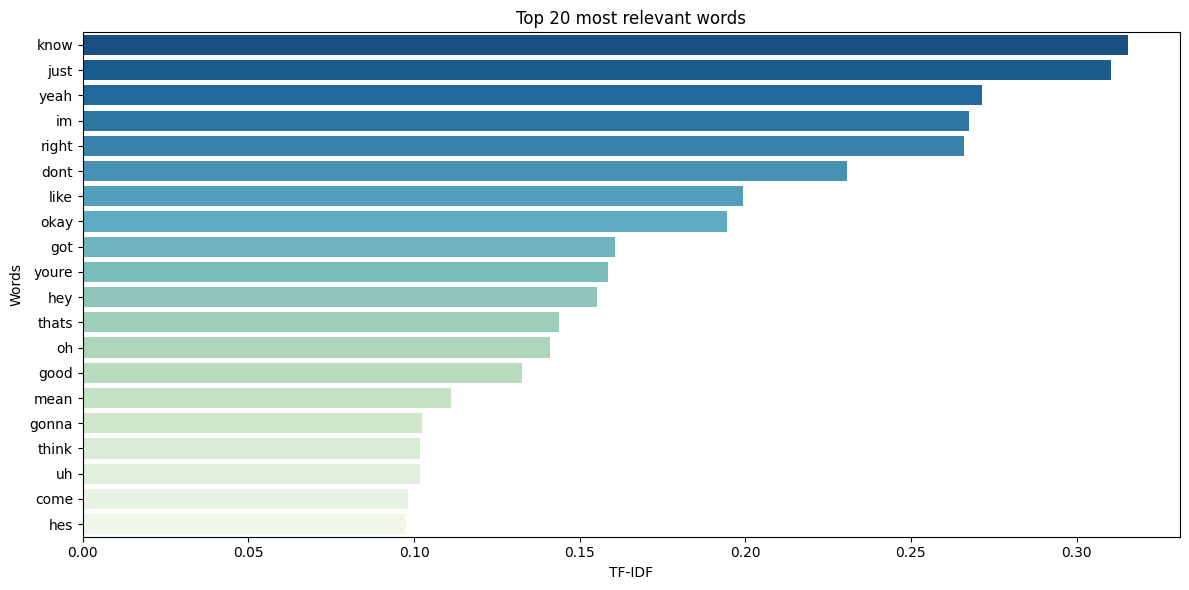

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vectorizer.fit([concatenated_script])
tfidf_values = tfidf_vectorizer.transform([concatenated_script]).toarray()[0]

top_20_indices = tfidf_values.argsort()[-20:][::-1]
top_20_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_20_indices]
top_20_tfidf_scores = tfidf_values[top_20_indices]
top_20_df = pd.DataFrame({'Words': top_20_words, 'TF-IDF': top_20_tfidf_scores})

plt.figure(figsize=(12, 6))
sns.barplot(x='TF-IDF', y='Words', data=top_20_df, palette='GnBu_r')
plt.xlabel('TF-IDF')
plt.ylabel('Words')
plt.title('Top 20 most relevant words')
plt.tight_layout()
plt.show()

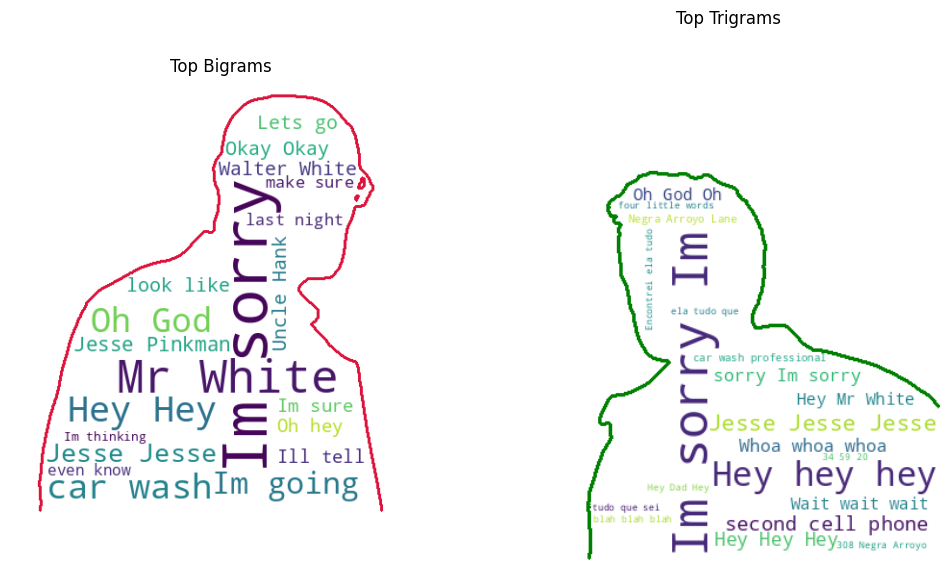

In [ ]:
# Get Walter & Jesse photo
urllib.request.urlretrieve("https://i.ibb.co/yF2C7h2/walter.png", "walter.png")
urllib.request.urlretrieve("https://i.ibb.co/6XWvqt7/jesse.png",   "jesse.png")

# Convert them to NumPy arrays for masking
walter_mask = np.array(Image.open("walter.png"))
walter_mask[walter_mask == 0] = 255
jesse_mask  = np.array(Image.open("jesse.png"))
jesse_mask [jesse_mask == 0]  = 255

bigram_wordcloud  = WordCloud(background_color='white', mask=walter_mask, contour_width=3, contour_color='crimson').generate_from_frequencies(top_bigrams)
trigram_wordcloud = WordCloud(background_color='white', mask= jesse_mask, contour_width=3, contour_color=  'green').generate_from_frequencies(top_trigrams)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Plotting word cloud for top bigrams
axes[0].imshow( bigram_wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title( 'Top Bigrams')

# Plotting word cloud for top trigrams
axes[1].imshow(trigram_wordcloud, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Top Trigrams')

plt.show()

##Episode and season rankings

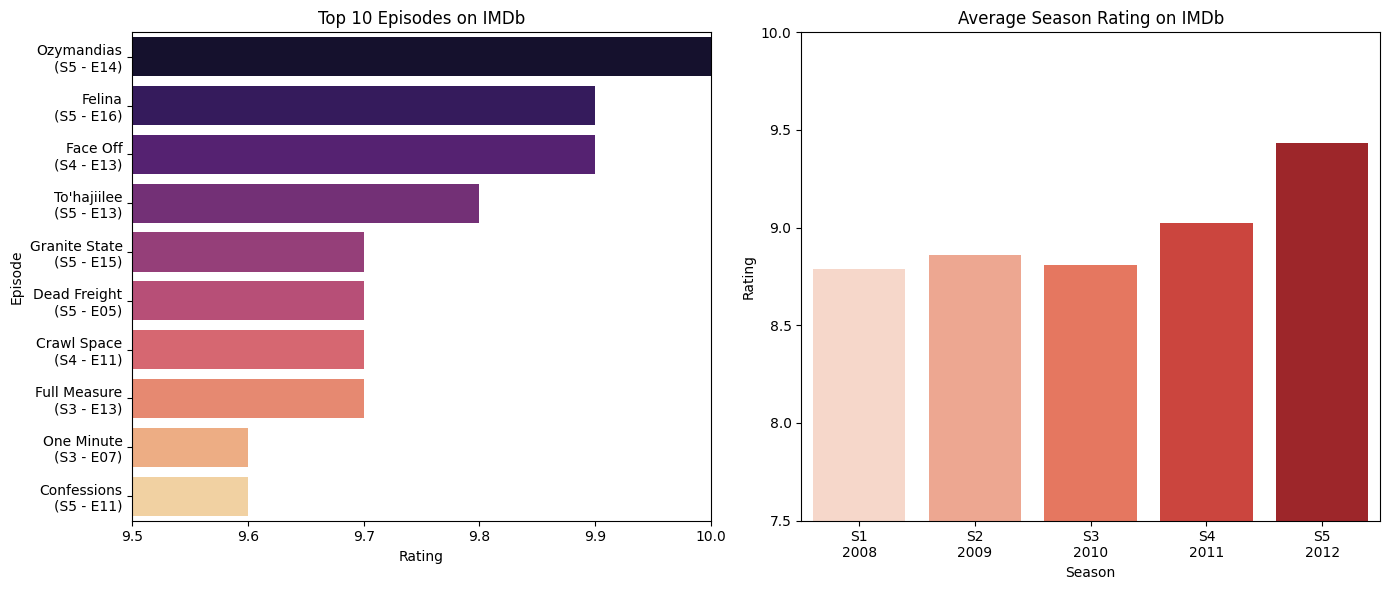

In [ ]:
sorted_df = df.sort_values(by='Rating_IMDB', ascending=False)
top_10_episodes = sorted_df.head(10)

# Plot 1: Top 10 Episodes on IMDb
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(y=top_10_episodes['Title'], x=top_10_episodes['Rating_IMDB'], palette='magma', orient='h')
plt.xlabel('Rating')
plt.ylabel('Episode')
plt.title('Top 10 Episodes on IMDb')

y_labels = [f"{t}\n(S{s} - E{e:02d})" for t, s, e in zip(top_10_episodes['Title'], top_10_episodes['Season'], top_10_episodes['Episode'])]
plt.gca().set_yticklabels(y_labels)

plt.xlim(9.5, 10)  # Set the x-axis limits from 9.5 to 10

# Plot 2: Average Season Rating on IMDb
season_avg_rating = df.groupby('Season')['Rating_IMDB'].mean()
seasons = ['S' + str(num) + '\n' + str(2007 + num) for num in season_avg_rating.index]
plt.subplot(1, 2, 2)
sns.barplot(x=seasons, y=season_avg_rating, palette='Reds')
plt.xlabel('Season')
plt.ylabel('Rating')
plt.title('Average Season Rating on IMDb')
plt.ylim(7.5, 10)  # Set the score limits from 7.5 to 10

plt.tight_layout()
plt.show()


##Episode characteristics

###Variation throughout the show

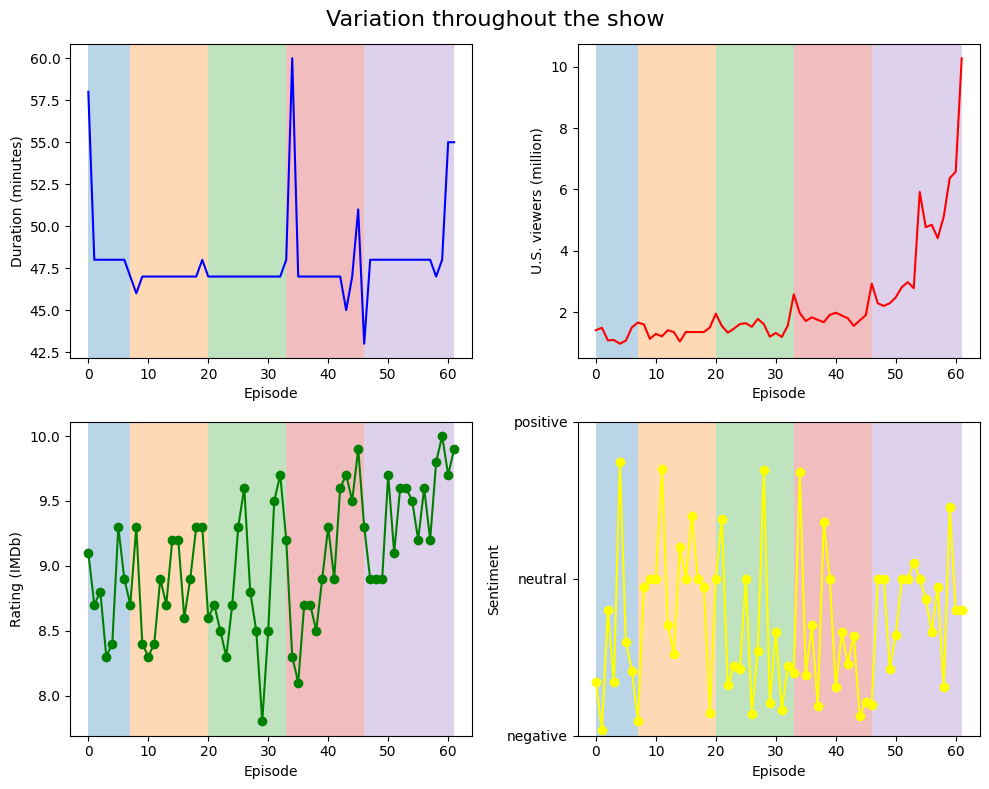

In [ ]:
# Main
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Variation throughout the show', fontsize=16)

# Duration
plt.subplot(2, 2, 1)
plt.plot(df.index, df['Duration_mins'], color='blue')
plt.xlabel('Episode')
plt.ylabel('Duration (minutes)')
season_boundaries = df[df['Season'].diff() != 0].index.tolist()
for i in range(len(season_boundaries)):
    start = season_boundaries[i]
    end = season_boundaries[i + 1] if i + 1 < len(season_boundaries) else df.index[-1]
    plt.axvspan(start, end, facecolor='C' + str(i % 10), alpha=0.3)

# U.S. viewers (million)
plt.subplot(2, 2, 2)
plt.plot(df.index, df['U.S. viewers_million'], color='red')
plt.xlabel('Episode')
plt.ylabel('U.S. viewers (million)')
season_boundaries = df[df['Season'].diff() != 0].index.tolist()
for i in range(len(season_boundaries)):
    start = season_boundaries[i]
    end = season_boundaries[i + 1] if i + 1 < len(season_boundaries) else df.index[-1]
    plt.axvspan(start, end, facecolor='C' + str(i % 10), alpha=0.3)

# Rating (IMDb)
plt.subplot(2, 2, 3)
plt.plot(df.index, df['Rating_IMDB'], marker='o', color='green')
plt.xlabel('Episode')
plt.ylabel('Rating (IMDb)')
season_boundaries = df[df['Season'].diff() != 0].index.tolist()
for i in range(len(season_boundaries)):
    start = season_boundaries[i]
    end = season_boundaries[i + 1] if i + 1 < len(season_boundaries) else df.index[-1]
    plt.axvspan(start, end, facecolor='C' + str(i % 10), alpha=0.3)

# Sentiment Score
plt.subplot(2, 2, 4)
plt.plot(df.index, df['Sentiment Score'], marker='o', color='yellow')
plt.xlabel('Episode')
plt.ylabel('Sentiment')
plt.ylim(-1, 1)
plt.yticks([-1, 0, 1], ['negative', 'neutral', 'positive'])
season_boundaries = df[df['Season'].diff() != 0].index.tolist()
for i in range(len(season_boundaries)):
    start = season_boundaries[i]
    end = season_boundaries[i + 1] if i + 1 < len(season_boundaries) else df.index[-1]
    plt.axvspan(start, end, facecolor='C' + str(i % 10), alpha=0.3)

# Display
plt.tight_layout()
plt.show()


###Correlation

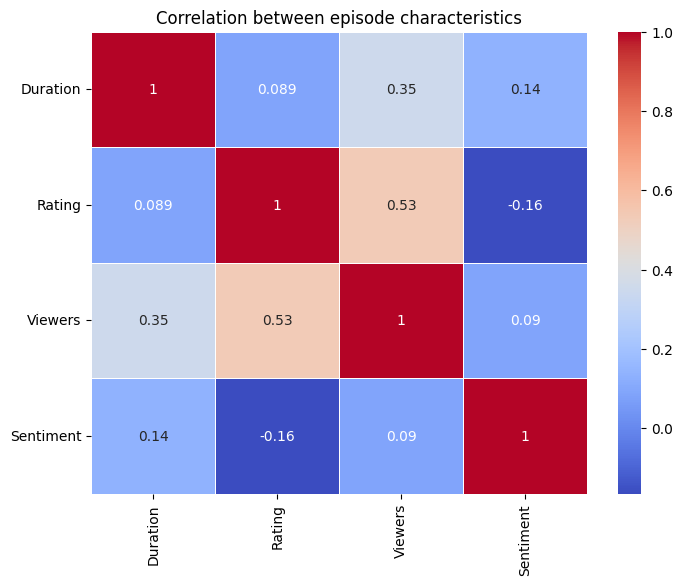

In [ ]:
# Create the correlation matrix
corr_matrix = df[['Duration_mins', 'Rating_IMDB', 'U.S. viewers_million', 'Sentiment Score']].corr()

# Generate a heatmap (visualization)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between episode characteristics')
labels = ['Duration', 'Rating', 'Viewers', 'Sentiment']
ax = plt.gca()
ax.set_xticklabels(labels, ha='center')
ax.set_yticklabels(labels, va='center')
plt.show()

##Characters

###Most occurences

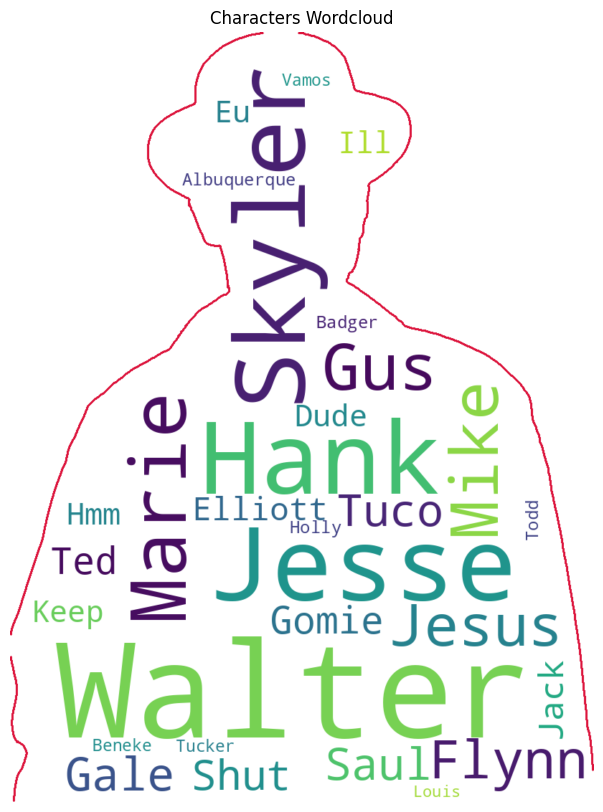

In [ ]:
# Get Heisenberg photo
image_url = "https://i.ibb.co/XsgnL9y/Walter-White-Transparent-Background.png"
urllib.request.urlretrieve(image_url, "Heisenberg.jpg")

# Convert it to a NumPy array for masking
image_mask = np.array(Image.open("Heisenberg.jpg"))
image_mask[image_mask == 0] = 255
word_frequencies = Counter(person_names)
top_names = dict(word_frequencies.most_common(30))
wordcloud = WordCloud(background_color='white', mask=image_mask, contour_width=3, contour_color='crimson').generate_from_frequencies(top_names)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Characters Wordcloud')
plt.show()

###Correlation with rating

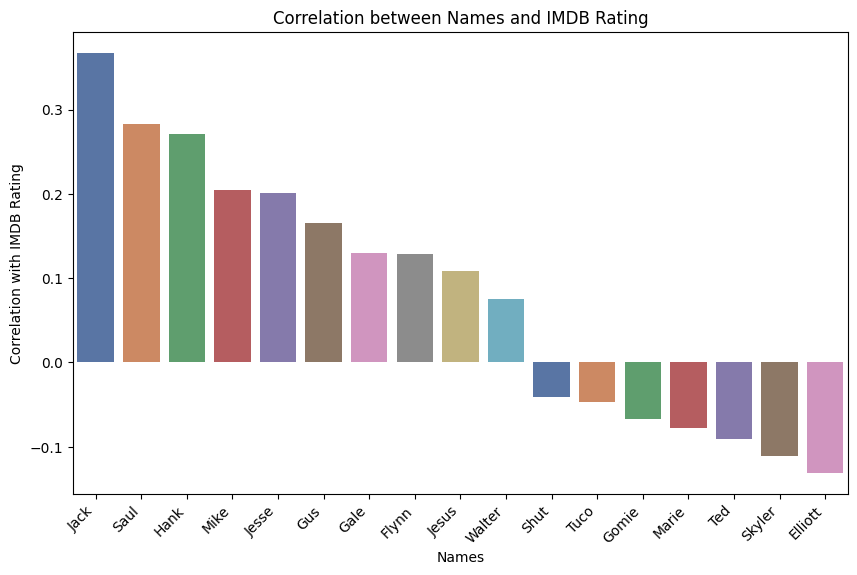

In [ ]:
name_columns = [name for name, _ in most_common_persons[:17]]
columns_to_plot = name_columns + ['Rating_IMDB']

correlation_matrix = new_df[columns_to_plot].corr()
last_row = correlation_matrix.iloc[-1].drop('Rating_IMDB')
last_row_sorted = last_row.sort_values(ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(x=last_row_sorted.index, y=last_row_sorted.values, palette='deep')
plt.xlabel('Names')
plt.ylabel('Correlation with IMDB Rating')
plt.title('Correlation between Names and IMDB Rating')
plt.xticks(rotation=45, ha='right')
plt.show()